* ##### *Overfitting can also be avoided by making the model robust through perterbations or simply introducing noise in the inputs and inner layers*

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import style
import pandas as pd
import seaborn as sns
import math

import torch 
from torch.optim import SGD

In [11]:
data = pd.read_csv('wheat.csv')
data = data.values

In [16]:
def dropout_regularizer(X, dropout=0.3):
    assert 0 <= dropout <= 1# In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros(X.shape, dtype=torch.float32)# In this case, all elements are kept
    if dropout == 0:
        return X
    mask = torch.rand(X.shape, dtype=torch.float32) > dropout
    return torch.multiply(X, mask) / (1.0 - dropout)

In [42]:
def relu(x):
    return torch.maximum(torch.tensor([0], dtype=torch.float32), x)

def init_params(layers):
    params = []
    for i in range(len(layers)-1):
        params.append(torch.randn((layers[i], layers[i+1]), requires_grad=True))
        params.append(torch.randn((layers[i+1]), requires_grad=True))
    return params

def xavier_initialization(layers):
    params = []
    for i in range(len(layers)-1):
        a = math.sqrt(6/(layers[i] + layers[i+1]))
        params.append(torch.tensor(np.random.uniform(-a, a, (layers[i], layers[i+1])), dtype=torch.float32, requires_grad=True))   
        #params.append(torch.Tensor((layers[i], layers[i+1]), requires_grad=True).uniform_(-a, a))
        params.append(torch.tensor(np.random.uniform(-a, a, (layers[i+1])), dtype=torch.float32, requires_grad=True))   
        #params.append(torch.randn(layers[i+1], dtype = torch.float32, requires_grad=True))
    return params

def forward(x, params, dropout = False): # we will apply dropout only when training is going on
    op = x
    for i in range(0, len(params)-2, 2):
        op = relu(torch.matmul(op, params[i]) + params[i+1])
        if dropout:
            op = dropout_regularizer(op)
    op = torch.matmul(op, params[-2]) + params[-1]
    return op # shape will be (16, 3)


def accuracy(x, y, params):
    op = forward(x, params) # shape is (210, 3)
    _, ind = torch.max(op, axis=1)
    return torch.sum(ind==y)/y.shape[0]

def pred(x, params):
    op = forward(x, params)


In [18]:
def train(dataset, num_epochs, lr, batch_size, params, optimizer, dropout = False, loss_fn=torch.nn.CrossEntropyLoss() ,
          print_every=3):
    acc = []
    losses =  []
    #data_x = dataset[:, :-1].clone().detach()
    #data_y = dataset[:, -1].clone().detach().to(torch.int)
    data_x = torch.tensor(dataset[:, :-1], dtype=torch.float32)
    data_y = torch.tensor(dataset[:, -1], dtype=torch.int)
    #losses.append(cross_entropy(data_y, forward(data_x, params)).item()) # this step won't be affective 
    for epoch in range(num_epochs):
        with torch.no_grad():
            acc.append(accuracy(data_x, data_y-1 , params))
        print(f'Accuracy {acc[-1]}')
        total_loss = 0
        #when the dataset is larger, we can instead do the sum of all the bacthes and take their averages    
       # if epoch%(num_epochs/10)==0:
           #print(f'epoch {epoch + 1}, loss {float(losses[-1]):f}, accuracy:{accuracy(data_x, data_y-1, params)}')
        #total_loss  =0
        #batches_processed = 0
        for i, batch in  enumerate(torch.utils.data.DataLoader(dataset , batch_size=batch_size), 0):
            inp = torch.tensor(batch[:, :-1], dtype=torch.float32)
            label = torch.tensor(batch[:, -1], dtype=int)
            op = forward(inp, params, dropout)
          
             
            current_loss = loss_fn(op, label-1) # -1 for making categories 0 indexed
            total_loss+= current_loss.item()
                     
                
            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()
            
            if i%print_every==0:
                print(f'Epoch[{epoch+1}], Current Loss: {current_loss.item()}')
            
            #batches_processed+= 1
        print("\n\n")
        losses.append(total_loss/(dataset.shape[0]/batch_size)) # average loss over all batches
    return losses, acc

Accuracy 0.4047619104385376
Epoch[1], Current Loss: 15.262468338012695
Epoch[1], Current Loss: 8.821674346923828
Epoch[1], Current Loss: 41.822818756103516
Epoch[1], Current Loss: 33.10752487182617
Epoch[1], Current Loss: 12.771428108215332



Accuracy 0.3333333432674408
Epoch[2], Current Loss: 24.01863670349121
Epoch[2], Current Loss: 8.445236206054688
Epoch[2], Current Loss: 23.031991958618164
Epoch[2], Current Loss: 25.14788055419922
Epoch[2], Current Loss: 7.644930839538574



Accuracy 0.3333333432674408
Epoch[3], Current Loss: 19.329246520996094
Epoch[3], Current Loss: 15.082928657531738
Epoch[3], Current Loss: 19.984710693359375
Epoch[3], Current Loss: 10.34382152557373
Epoch[3], Current Loss: 1.4334102869033813



Accuracy 0.3333333432674408
Epoch[4], Current Loss: 26.687049865722656
Epoch[4], Current Loss: 16.976062774658203
Epoch[4], Current Loss: 11.246810913085938
Epoch[4], Current Loss: 15.716496467590332
Epoch[4], Current Loss: 4.053502559661865



Accuracy 0.3333333432674

Epoch[53], Current Loss: 0.11479222029447556
Epoch[53], Current Loss: 1.8120012283325195
Epoch[53], Current Loss: 0.32078060507774353



Accuracy 0.3333333432674408
Epoch[54], Current Loss: 3.145695924758911
Epoch[54], Current Loss: 0.4302799701690674
Epoch[54], Current Loss: 0.13356265425682068
Epoch[54], Current Loss: 1.5315194129943848
Epoch[54], Current Loss: 0.27836063504219055



Accuracy 0.3333333432674408
Epoch[55], Current Loss: 2.833136796951294
Epoch[55], Current Loss: 0.3452760875225067
Epoch[55], Current Loss: 0.1186455562710762
Epoch[55], Current Loss: 1.987744927406311
Epoch[55], Current Loss: 0.23950886726379395



Accuracy 0.3333333432674408
Epoch[56], Current Loss: 3.108389139175415
Epoch[56], Current Loss: 0.33019158244132996
Epoch[56], Current Loss: 0.15978656709194183
Epoch[56], Current Loss: 1.582927942276001
Epoch[56], Current Loss: 0.2649371325969696



Accuracy 0.3333333432674408
Epoch[57], Current Loss: 3.051469564437866
Epoch[57], Current Loss: 0.294104576110

Epoch[103], Current Loss: 0.4643275737762451
Epoch[103], Current Loss: 0.13263234496116638
Epoch[103], Current Loss: 1.6513328552246094
Epoch[103], Current Loss: 0.4490056037902832



Accuracy 0.3333333432674408
Epoch[104], Current Loss: 2.5565567016601562
Epoch[104], Current Loss: 0.3791956603527069
Epoch[104], Current Loss: 0.3000338673591614
Epoch[104], Current Loss: 1.2732361555099487
Epoch[104], Current Loss: 0.5541213154792786



Accuracy 0.3333333432674408
Epoch[105], Current Loss: 2.3352770805358887
Epoch[105], Current Loss: 0.37540897727012634
Epoch[105], Current Loss: 0.1292460858821869
Epoch[105], Current Loss: 1.3236297369003296
Epoch[105], Current Loss: 0.4989990293979645



Accuracy 0.3333333432674408
Epoch[106], Current Loss: 2.258593797683716
Epoch[106], Current Loss: 0.3155616223812103
Epoch[106], Current Loss: 0.12213630229234695
Epoch[106], Current Loss: 1.847412347793579
Epoch[106], Current Loss: 0.3532480299472809



Accuracy 0.3333333432674408
Epoch[107], Current 

Epoch[142], Current Loss: 1.3695820569992065
Epoch[142], Current Loss: 0.7109766602516174



Accuracy 0.3333333432674408
Epoch[143], Current Loss: 2.4085404872894287
Epoch[143], Current Loss: 0.2564804255962372
Epoch[143], Current Loss: 0.23174186050891876
Epoch[143], Current Loss: 1.4439103603363037
Epoch[143], Current Loss: 0.3658321499824524



Accuracy 0.3333333432674408
Epoch[144], Current Loss: 2.2433969974517822
Epoch[144], Current Loss: 0.21949103474617004
Epoch[144], Current Loss: 0.3237168788909912
Epoch[144], Current Loss: 1.0336410999298096
Epoch[144], Current Loss: 0.6782614588737488



Accuracy 0.3380952477455139
Epoch[145], Current Loss: 1.96768057346344
Epoch[145], Current Loss: 0.28065332770347595
Epoch[145], Current Loss: 0.3718273639678955
Epoch[145], Current Loss: 1.5015690326690674
Epoch[145], Current Loss: 0.3945080041885376



Accuracy 0.3333333432674408
Epoch[146], Current Loss: 2.366135597229004
Epoch[146], Current Loss: 0.30139583349227905
Epoch[146], Current 

Epoch[181], Current Loss: 0.6790649890899658
Epoch[181], Current Loss: 0.20249249041080475
Epoch[181], Current Loss: 0.8106226921081543
Epoch[181], Current Loss: 0.34648823738098145



Accuracy 0.5904762148857117
Epoch[182], Current Loss: 1.893560528755188
Epoch[182], Current Loss: 0.47830531001091003
Epoch[182], Current Loss: 0.2944055497646332
Epoch[182], Current Loss: 1.5629287958145142
Epoch[182], Current Loss: 0.6328664422035217



Accuracy 0.3619047701358795
Epoch[183], Current Loss: 1.9730019569396973
Epoch[183], Current Loss: 0.4334351420402527
Epoch[183], Current Loss: 0.34595030546188354
Epoch[183], Current Loss: 1.2359364032745361
Epoch[183], Current Loss: 0.752227246761322



Accuracy 0.34285715222358704
Epoch[184], Current Loss: 1.9093109369277954
Epoch[184], Current Loss: 0.5233528017997742
Epoch[184], Current Loss: 0.3514845073223114
Epoch[184], Current Loss: 1.702695608139038
Epoch[184], Current Loss: 0.582621693611145



Accuracy 0.3380952477455139
Epoch[185], Current 

Epoch[222], Current Loss: 0.5794846415519714
Epoch[222], Current Loss: 0.24618473649024963
Epoch[222], Current Loss: 0.938734233379364
Epoch[222], Current Loss: 0.542026698589325



Accuracy 0.36666667461395264
Epoch[223], Current Loss: 1.8820335865020752
Epoch[223], Current Loss: 0.43717268109321594
Epoch[223], Current Loss: 0.22903257608413696
Epoch[223], Current Loss: 0.8905022144317627
Epoch[223], Current Loss: 0.7083643078804016



Accuracy 0.3619047701358795
Epoch[224], Current Loss: 1.7819997072219849
Epoch[224], Current Loss: 0.3819912374019623
Epoch[224], Current Loss: 0.3467038869857788
Epoch[224], Current Loss: 1.6275779008865356
Epoch[224], Current Loss: 0.5641898512840271



Accuracy 0.36666667461395264
Epoch[225], Current Loss: 1.8410438299179077
Epoch[225], Current Loss: 0.33599039912223816
Epoch[225], Current Loss: 0.483608603477478
Epoch[225], Current Loss: 1.1645746231079102
Epoch[225], Current Loss: 0.6378049254417419



Accuracy 0.6571428775787354
Epoch[226], Curren




Accuracy 0.3571428656578064
Epoch[263], Current Loss: 1.6941624879837036
Epoch[263], Current Loss: 0.5507151484489441
Epoch[263], Current Loss: 0.2976363003253937
Epoch[263], Current Loss: 1.4520021677017212
Epoch[263], Current Loss: 0.7387943863868713



Accuracy 0.3619047701358795
Epoch[264], Current Loss: 1.915331244468689
Epoch[264], Current Loss: 0.6339709758758545
Epoch[264], Current Loss: 0.4406053125858307
Epoch[264], Current Loss: 1.6751463413238525
Epoch[264], Current Loss: 0.3918481469154358



Accuracy 0.6190476417541504
Epoch[265], Current Loss: 2.100222587585449
Epoch[265], Current Loss: 0.47325563430786133
Epoch[265], Current Loss: 0.27651268243789673
Epoch[265], Current Loss: 0.9166850447654724
Epoch[265], Current Loss: 0.7018063068389893



Accuracy 0.6238095164299011
Epoch[266], Current Loss: 1.6845484972000122
Epoch[266], Current Loss: 0.43306583166122437
Epoch[266], Current Loss: 0.2755429744720459
Epoch[266], Current Loss: 1.0414228439331055
Epoch[266], Current 

Epoch[302], Current Loss: 0.2567558288574219
Epoch[302], Current Loss: 0.9492912888526917
Epoch[302], Current Loss: 0.6892532110214233



Accuracy 0.6428571343421936
Epoch[303], Current Loss: 1.4589735269546509
Epoch[303], Current Loss: 0.5059691071510315
Epoch[303], Current Loss: 0.3879738748073578
Epoch[303], Current Loss: 1.3711116313934326
Epoch[303], Current Loss: 0.6360040307044983



Accuracy 0.6714285612106323
Epoch[304], Current Loss: 1.9404007196426392
Epoch[304], Current Loss: 0.5029566287994385
Epoch[304], Current Loss: 0.38975343108177185
Epoch[304], Current Loss: 0.7641992568969727
Epoch[304], Current Loss: 0.7545024156570435



Accuracy 0.6428571343421936
Epoch[305], Current Loss: 1.6995149850845337
Epoch[305], Current Loss: 0.6379189491271973
Epoch[305], Current Loss: 0.29512134194374084
Epoch[305], Current Loss: 1.326371431350708
Epoch[305], Current Loss: 0.6440840363502502



Accuracy 0.37142857909202576
Epoch[306], Current Loss: 1.8002023696899414
Epoch[306], Current

Epoch[346], Current Loss: 1.7739059925079346
Epoch[346], Current Loss: 0.5155826210975647
Epoch[346], Current Loss: 0.5312983393669128
Epoch[346], Current Loss: 0.8887767195701599
Epoch[346], Current Loss: 0.6601797342300415



Accuracy 0.6476190686225891
Epoch[347], Current Loss: 1.694960355758667
Epoch[347], Current Loss: 0.4683848023414612
Epoch[347], Current Loss: 0.31316694617271423
Epoch[347], Current Loss: 1.2759438753128052
Epoch[347], Current Loss: 0.6318355798721313



Accuracy 0.7333333492279053
Epoch[348], Current Loss: 1.460969090461731
Epoch[348], Current Loss: 0.28586646914482117
Epoch[348], Current Loss: 0.5163405537605286
Epoch[348], Current Loss: 1.1996816396713257
Epoch[348], Current Loss: 0.8128384351730347



Accuracy 0.6142857074737549
Epoch[349], Current Loss: 1.929193139076233
Epoch[349], Current Loss: 0.5308963060379028
Epoch[349], Current Loss: 0.42170751094818115
Epoch[349], Current Loss: 1.133480191230774
Epoch[349], Current Loss: 0.6997755765914917



Accur

Epoch[385], Current Loss: 0.5767579674720764



Accuracy 0.6714285612106323
Epoch[386], Current Loss: 1.9242920875549316
Epoch[386], Current Loss: 0.5266559720039368
Epoch[386], Current Loss: 0.32941633462905884
Epoch[386], Current Loss: 1.354577660560608
Epoch[386], Current Loss: 0.6491988897323608



Accuracy 0.6571428775787354
Epoch[387], Current Loss: 1.222548246383667
Epoch[387], Current Loss: 0.38457921147346497
Epoch[387], Current Loss: 0.4454411268234253
Epoch[387], Current Loss: 1.5075911283493042
Epoch[387], Current Loss: 0.4686201214790344



Accuracy 0.6523809432983398
Epoch[388], Current Loss: 1.999934434890747
Epoch[388], Current Loss: 0.4710352420806885
Epoch[388], Current Loss: 0.4093867242336273
Epoch[388], Current Loss: 1.0001752376556396
Epoch[388], Current Loss: 0.5091254711151123



Accuracy 0.7047619223594666
Epoch[389], Current Loss: 1.377539038658142
Epoch[389], Current Loss: 0.5455093383789062
Epoch[389], Current Loss: 0.4963497817516327
Epoch[389], Current Los

Epoch[428], Current Loss: 1.3500044345855713
Epoch[428], Current Loss: 0.7134761214256287
Epoch[428], Current Loss: 0.47387534379959106
Epoch[428], Current Loss: 1.007834553718567
Epoch[428], Current Loss: 0.6274467706680298



Accuracy 0.7476190328598022
Epoch[429], Current Loss: 1.8950542211532593
Epoch[429], Current Loss: 0.5088701248168945
Epoch[429], Current Loss: 0.4090252220630646
Epoch[429], Current Loss: 0.915502667427063
Epoch[429], Current Loss: 0.7548156380653381



Accuracy 0.7428571581840515
Epoch[430], Current Loss: 1.6599980592727661
Epoch[430], Current Loss: 0.7464995384216309
Epoch[430], Current Loss: 0.48291945457458496
Epoch[430], Current Loss: 1.0086886882781982
Epoch[430], Current Loss: 0.928087592124939



Accuracy 0.723809540271759
Epoch[431], Current Loss: 1.4491106271743774
Epoch[431], Current Loss: 0.42546266317367554
Epoch[431], Current Loss: 0.49748286604881287
Epoch[431], Current Loss: 1.1660696268081665
Epoch[431], Current Loss: 0.8629043698310852



Accu

Epoch[476], Current Loss: 0.30998849868774414
Epoch[476], Current Loss: 0.6113680601119995
Epoch[476], Current Loss: 0.6269986629486084



Accuracy 0.7047619223594666
Epoch[477], Current Loss: 1.6974897384643555
Epoch[477], Current Loss: 0.755707323551178
Epoch[477], Current Loss: 0.3051513731479645
Epoch[477], Current Loss: 0.9248539209365845
Epoch[477], Current Loss: 0.6980404257774353



Accuracy 0.738095223903656
Epoch[478], Current Loss: 1.3021701574325562
Epoch[478], Current Loss: 0.6776213645935059
Epoch[478], Current Loss: 0.4607045352458954
Epoch[478], Current Loss: 0.9021269083023071
Epoch[478], Current Loss: 0.9426475167274475



Accuracy 0.6857143044471741
Epoch[479], Current Loss: 1.6613845825195312
Epoch[479], Current Loss: 0.8328279256820679
Epoch[479], Current Loss: 0.36117562651634216
Epoch[479], Current Loss: 0.7395151853561401
Epoch[479], Current Loss: 0.732414722442627



Accuracy 0.6952381134033203
Epoch[480], Current Loss: 1.5178964138031006
Epoch[480], Current Lo

Epoch[527], Current Loss: 0.4252091944217682
Epoch[527], Current Loss: 0.34061580896377563
Epoch[527], Current Loss: 0.5621134638786316
Epoch[527], Current Loss: 0.9801961183547974



Accuracy 0.7857142686843872
Epoch[528], Current Loss: 1.312508225440979
Epoch[528], Current Loss: 0.7767683863639832
Epoch[528], Current Loss: 0.4393703043460846
Epoch[528], Current Loss: 0.921500563621521
Epoch[528], Current Loss: 0.6411722898483276



Accuracy 0.6619047522544861
Epoch[529], Current Loss: 1.6040358543395996
Epoch[529], Current Loss: 0.645595133304596
Epoch[529], Current Loss: 0.5744668245315552
Epoch[529], Current Loss: 0.6554372906684875
Epoch[529], Current Loss: 0.7245551943778992



Accuracy 0.723809540271759
Epoch[530], Current Loss: 1.6134148836135864
Epoch[530], Current Loss: 0.5464433431625366
Epoch[530], Current Loss: 0.5181162357330322
Epoch[530], Current Loss: 0.9983317852020264
Epoch[530], Current Loss: 0.7142890095710754



Accuracy 0.723809540271759
Epoch[531], Current Loss:

Epoch[575], Current Loss: 0.5305524468421936
Epoch[575], Current Loss: 0.6287437081336975
Epoch[575], Current Loss: 0.5795983076095581



Accuracy 0.8047618865966797
Epoch[576], Current Loss: 1.3808706998825073
Epoch[576], Current Loss: 0.5170265436172485
Epoch[576], Current Loss: 0.39059391617774963
Epoch[576], Current Loss: 0.8486849665641785
Epoch[576], Current Loss: 0.8821482062339783



Accuracy 0.761904776096344
Epoch[577], Current Loss: 1.4372823238372803
Epoch[577], Current Loss: 0.5887267589569092
Epoch[577], Current Loss: 0.4576845169067383
Epoch[577], Current Loss: 0.7171209454536438
Epoch[577], Current Loss: 0.5079804062843323



Accuracy 0.8047618865966797
Epoch[578], Current Loss: 1.2900478839874268
Epoch[578], Current Loss: 0.7037917971611023
Epoch[578], Current Loss: 0.49846503138542175
Epoch[578], Current Loss: 0.9144385457038879
Epoch[578], Current Loss: 0.7478750944137573



Accuracy 0.7047619223594666
Epoch[579], Current Loss: 1.496598482131958
Epoch[579], Current L

Epoch[620], Current Loss: 0.5796670913696289



Accuracy 0.8238095045089722
Epoch[621], Current Loss: 1.2294765710830688
Epoch[621], Current Loss: 0.6350014805793762
Epoch[621], Current Loss: 0.24784749746322632
Epoch[621], Current Loss: 0.9482084512710571
Epoch[621], Current Loss: 0.6081821918487549



Accuracy 0.8142856955528259
Epoch[622], Current Loss: 1.0593065023422241
Epoch[622], Current Loss: 0.7401516437530518
Epoch[622], Current Loss: 0.39097100496292114
Epoch[622], Current Loss: 0.8196800947189331
Epoch[622], Current Loss: 0.5535505414009094



Accuracy 0.800000011920929
Epoch[623], Current Loss: 1.5565211772918701
Epoch[623], Current Loss: 0.3106880486011505
Epoch[623], Current Loss: 0.45269787311553955
Epoch[623], Current Loss: 0.5979174971580505
Epoch[623], Current Loss: 0.7524335384368896



Accuracy 0.7857142686843872
Epoch[624], Current Loss: 1.6930296421051025
Epoch[624], Current Loss: 0.7260386347770691
Epoch[624], Current Loss: 0.33231204748153687
Epoch[624], Curren

Epoch[670], Current Loss: 0.6744710206985474
Epoch[670], Current Loss: 0.4541853070259094



Accuracy 0.8238095045089722
Epoch[671], Current Loss: 1.3032444715499878
Epoch[671], Current Loss: 0.3751077353954315
Epoch[671], Current Loss: 0.36217936873435974
Epoch[671], Current Loss: 0.6176812648773193
Epoch[671], Current Loss: 0.49776726961135864



Accuracy 0.8285714387893677
Epoch[672], Current Loss: 1.3691083192825317
Epoch[672], Current Loss: 0.38585999608039856
Epoch[672], Current Loss: 0.3613879084587097
Epoch[672], Current Loss: 0.7164074778556824
Epoch[672], Current Loss: 0.4552712142467499



Accuracy 0.8333333134651184
Epoch[673], Current Loss: 1.2648203372955322
Epoch[673], Current Loss: 0.48862284421920776
Epoch[673], Current Loss: 0.13922223448753357
Epoch[673], Current Loss: 0.6282802224159241
Epoch[673], Current Loss: 0.5432039499282837



Accuracy 0.8476190567016602
Epoch[674], Current Loss: 1.0851304531097412
Epoch[674], Current Loss: 0.491983562707901
Epoch[674], Curre

Epoch[720], Current Loss: 0.5345543026924133
Epoch[720], Current Loss: 0.5380513668060303
Epoch[720], Current Loss: 0.6758818030357361
Epoch[720], Current Loss: 0.5995045304298401



Accuracy 0.8428571224212646
Epoch[721], Current Loss: 1.165693759918213
Epoch[721], Current Loss: 0.6443014144897461
Epoch[721], Current Loss: 0.3511480391025543
Epoch[721], Current Loss: 0.8179206848144531
Epoch[721], Current Loss: 0.5727453231811523



Accuracy 0.8238095045089722
Epoch[722], Current Loss: 1.4004572629928589
Epoch[722], Current Loss: 0.8227877020835876
Epoch[722], Current Loss: 0.5091080665588379
Epoch[722], Current Loss: 0.50778728723526
Epoch[722], Current Loss: 0.5739108920097351



Accuracy 0.8285714387893677
Epoch[723], Current Loss: 0.9820775985717773
Epoch[723], Current Loss: 0.3917810916900635
Epoch[723], Current Loss: 0.377590537071228
Epoch[723], Current Loss: 0.690036952495575
Epoch[723], Current Loss: 0.5991647839546204



Accuracy 0.8666666746139526
Epoch[724], Current Loss: 

Epoch[763], Current Loss: 0.7221801280975342
Epoch[763], Current Loss: 0.6543123722076416



Accuracy 0.8476190567016602
Epoch[764], Current Loss: 1.3074288368225098
Epoch[764], Current Loss: 0.5317777395248413
Epoch[764], Current Loss: 0.32409727573394775
Epoch[764], Current Loss: 0.5424529910087585
Epoch[764], Current Loss: 0.48942938446998596



Accuracy 0.8380952477455139
Epoch[765], Current Loss: 1.165086030960083
Epoch[765], Current Loss: 0.4735778570175171
Epoch[765], Current Loss: 0.48634275794029236
Epoch[765], Current Loss: 0.5746605396270752
Epoch[765], Current Loss: 0.5318490266799927



Accuracy 0.8428571224212646
Epoch[766], Current Loss: 1.273976445198059
Epoch[766], Current Loss: 0.6591627597808838
Epoch[766], Current Loss: 0.4965458810329437
Epoch[766], Current Loss: 0.7022837996482849
Epoch[766], Current Loss: 0.5288565754890442



Accuracy 0.8238095045089722
Epoch[767], Current Loss: 1.4299448728561401
Epoch[767], Current Loss: 0.4804691672325134
Epoch[767], Current 

Epoch[812], Current Loss: 0.48172682523727417



Accuracy 0.8571428656578064
Epoch[813], Current Loss: 1.1328060626983643
Epoch[813], Current Loss: 0.4532492458820343
Epoch[813], Current Loss: 0.3292003870010376
Epoch[813], Current Loss: 0.5279767513275146
Epoch[813], Current Loss: 0.6248103976249695



Accuracy 0.8857142925262451
Epoch[814], Current Loss: 0.9681594967842102
Epoch[814], Current Loss: 0.673682689666748
Epoch[814], Current Loss: 0.3740643858909607
Epoch[814], Current Loss: 0.8061738014221191
Epoch[814], Current Loss: 0.5794655680656433



Accuracy 0.8285714387893677
Epoch[815], Current Loss: 1.1893296241760254
Epoch[815], Current Loss: 0.7428390979766846
Epoch[815], Current Loss: 0.5068420767784119
Epoch[815], Current Loss: 0.568059504032135
Epoch[815], Current Loss: 0.3934115469455719



Accuracy 0.8476190567016602
Epoch[816], Current Loss: 1.0145070552825928
Epoch[816], Current Loss: 0.8963161110877991
Epoch[816], Current Loss: 0.3327963650226593
Epoch[816], Current Lo

Epoch[857], Current Loss: 0.6142100095748901



Accuracy 0.8857142925262451
Epoch[858], Current Loss: 1.0681588649749756
Epoch[858], Current Loss: 0.49491560459136963
Epoch[858], Current Loss: 0.23579920828342438
Epoch[858], Current Loss: 0.48598843812942505
Epoch[858], Current Loss: 0.7717071771621704



Accuracy 0.8666666746139526
Epoch[859], Current Loss: 1.102146863937378
Epoch[859], Current Loss: 0.9395737051963806
Epoch[859], Current Loss: 0.5286491513252258
Epoch[859], Current Loss: 0.5089373588562012
Epoch[859], Current Loss: 0.6584482789039612



Accuracy 0.8619047403335571
Epoch[860], Current Loss: 1.2383898496627808
Epoch[860], Current Loss: 0.6161176562309265
Epoch[860], Current Loss: 0.3321749269962311
Epoch[860], Current Loss: 0.5564050078392029
Epoch[860], Current Loss: 0.576115608215332



Accuracy 0.8666666746139526
Epoch[861], Current Loss: 1.1820012331008911
Epoch[861], Current Loss: 0.684991180896759
Epoch[861], Current Loss: 0.32885661721229553
Epoch[861], Current 

Epoch[913], Current Loss: 0.3930356800556183
Epoch[913], Current Loss: 0.5019788146018982
Epoch[913], Current Loss: 0.8261118531227112



Accuracy 0.8666666746139526
Epoch[914], Current Loss: 1.2957230806350708
Epoch[914], Current Loss: 0.621131420135498
Epoch[914], Current Loss: 0.2625373601913452
Epoch[914], Current Loss: 0.921499490737915
Epoch[914], Current Loss: 0.6599889397621155



Accuracy 0.8380952477455139
Epoch[915], Current Loss: 0.9737141132354736
Epoch[915], Current Loss: 0.41520681977272034
Epoch[915], Current Loss: 0.4465014934539795
Epoch[915], Current Loss: 0.7161359786987305
Epoch[915], Current Loss: 0.533427357673645



Accuracy 0.8619047403335571
Epoch[916], Current Loss: 1.0801628828048706
Epoch[916], Current Loss: 0.6837058067321777
Epoch[916], Current Loss: 0.5359001755714417
Epoch[916], Current Loss: 0.6513422131538391
Epoch[916], Current Loss: 0.5624679923057556



Accuracy 0.8809523582458496
Epoch[917], Current Loss: 1.0648951530456543
Epoch[917], Current Los

Epoch[962], Current Loss: 0.48258090019226074



Accuracy 0.8666666746139526
Epoch[963], Current Loss: 0.875159502029419
Epoch[963], Current Loss: 0.4536730647087097
Epoch[963], Current Loss: 0.13482952117919922
Epoch[963], Current Loss: 0.523867130279541
Epoch[963], Current Loss: 0.5394527316093445



Accuracy 0.8857142925262451
Epoch[964], Current Loss: 0.8152037262916565
Epoch[964], Current Loss: 1.0321259498596191
Epoch[964], Current Loss: 0.44350922107696533
Epoch[964], Current Loss: 0.4270973801612854
Epoch[964], Current Loss: 0.7494702339172363



Accuracy 0.8904761672019958
Epoch[965], Current Loss: 1.0529423952102661
Epoch[965], Current Loss: 0.4229260981082916
Epoch[965], Current Loss: 0.3925977349281311
Epoch[965], Current Loss: 0.6314495801925659
Epoch[965], Current Loss: 0.5944032669067383



Accuracy 0.8809523582458496
Epoch[966], Current Loss: 0.8169499039649963
Epoch[966], Current Loss: 0.5023286938667297
Epoch[966], Current Loss: 0.2911229133605957
Epoch[966], Current 

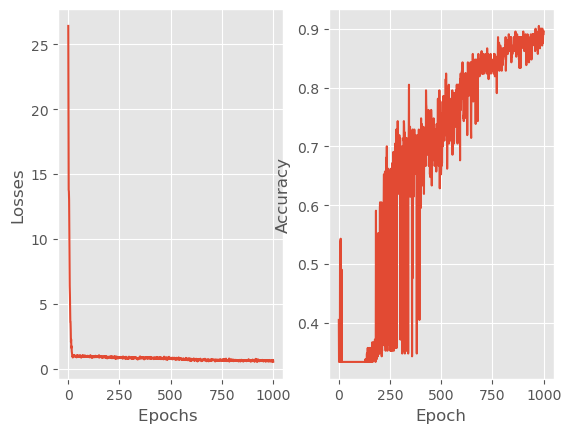

In [27]:
# hparameters and models
layer = [7,8,3]
num_epochs = 1000
batch_size = 16
params1 = init_params(layer)
lr = 1e-3
optimizer1 = SGD(params=params1, lr=lr)



# simple model without any hidden layer
import warnings
warnings.filterwarnings("ignore")
losses, acc = train(dataset=torch.tensor(data, dtype=torch.float32), num_epochs=num_epochs, lr=lr, 
                                batch_size=batch_size, params=params1, optimizer=optimizer1, dropout = True)            
style.use("ggplot")
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel("Epochs ")
plt.ylabel("Losses")
#plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Accuracy 0.3333333432674408
Epoch[1], Current Loss: 53.7750244140625
Epoch[1], Current Loss: 31.894485473632812
Epoch[1], Current Loss: 82.34415435791016
Epoch[1], Current Loss: 21.09601593017578
Epoch[1], Current Loss: 19.47210121154785



Accuracy 0.3333333432674408
Epoch[2], Current Loss: 39.394317626953125
Epoch[2], Current Loss: 14.087626457214355
Epoch[2], Current Loss: 32.28622055053711
Epoch[2], Current Loss: 17.140649795532227
Epoch[2], Current Loss: 14.04419231414795



Accuracy 0.3333333432674408
Epoch[3], Current Loss: 21.663867950439453
Epoch[3], Current Loss: 6.143793106079102
Epoch[3], Current Loss: 19.57773208618164
Epoch[3], Current Loss: 13.728179931640625
Epoch[3], Current Loss: 15.212162971496582



Accuracy 0.3333333432674408
Epoch[4], Current Loss: 23.610820770263672
Epoch[4], Current Loss: 9.916937828063965
Epoch[4], Current Loss: 10.225025177001953
Epoch[4], Current Loss: 12.462167739868164
Epoch[4], Current Loss: 12.888526916503906



Accuracy 0.628571450710296

Epoch[50], Current Loss: 0.5665522813796997
Epoch[50], Current Loss: 0.4592304229736328
Epoch[50], Current Loss: 1.26199471950531
Epoch[50], Current Loss: 0.34861060976982117



Accuracy 0.6142857074737549
Epoch[51], Current Loss: 2.24638295173645
Epoch[51], Current Loss: 0.4734843969345093
Epoch[51], Current Loss: 0.5844122171401978
Epoch[51], Current Loss: 1.8775956630706787
Epoch[51], Current Loss: 0.8510370850563049



Accuracy 0.6142857074737549
Epoch[52], Current Loss: 1.9484896659851074
Epoch[52], Current Loss: 0.7455892562866211
Epoch[52], Current Loss: 0.5936603546142578
Epoch[52], Current Loss: 1.7117424011230469
Epoch[52], Current Loss: 0.531559407711029



Accuracy 0.6095238327980042
Epoch[53], Current Loss: 1.9984714984893799
Epoch[53], Current Loss: 0.5275692939758301
Epoch[53], Current Loss: 0.5617167949676514
Epoch[53], Current Loss: 1.5494436025619507
Epoch[53], Current Loss: 0.7325525879859924



Accuracy 0.6095238327980042
Epoch[54], Current Loss: 2.152268648147583
E

Epoch[99], Current Loss: 2.0953116416931152
Epoch[99], Current Loss: 0.46000638604164124
Epoch[99], Current Loss: 0.3523692190647125
Epoch[99], Current Loss: 1.213219165802002
Epoch[99], Current Loss: 0.7777560949325562



Accuracy 0.6238095164299011
Epoch[100], Current Loss: 1.9781140089035034
Epoch[100], Current Loss: 0.5340863466262817
Epoch[100], Current Loss: 0.49671295285224915
Epoch[100], Current Loss: 1.0110492706298828
Epoch[100], Current Loss: 0.7281407117843628



Accuracy 0.6333333253860474
Epoch[101], Current Loss: 1.9301296472549438
Epoch[101], Current Loss: 0.6753451824188232
Epoch[101], Current Loss: 0.4339157044887543
Epoch[101], Current Loss: 1.0393178462982178
Epoch[101], Current Loss: 0.7371050715446472



Accuracy 0.6476190686225891
Epoch[102], Current Loss: 1.9785504341125488
Epoch[102], Current Loss: 0.5823045969009399
Epoch[102], Current Loss: 0.6051845550537109
Epoch[102], Current Loss: 1.3831331729888916
Epoch[102], Current Loss: 0.5234113931655884



Accuracy

Epoch[139], Current Loss: 2.0278501510620117
Epoch[139], Current Loss: 0.5272471308708191
Epoch[139], Current Loss: 0.6903703808784485
Epoch[139], Current Loss: 1.0387672185897827
Epoch[139], Current Loss: 0.8505467176437378



Accuracy 0.6523809432983398
Epoch[140], Current Loss: 1.903564691543579
Epoch[140], Current Loss: 0.6593621373176575
Epoch[140], Current Loss: 0.3598816394805908
Epoch[140], Current Loss: 1.246534824371338
Epoch[140], Current Loss: 0.5274077653884888



Accuracy 0.6238095164299011
Epoch[141], Current Loss: 2.2423758506774902
Epoch[141], Current Loss: 0.604953944683075
Epoch[141], Current Loss: 0.3066311180591583
Epoch[141], Current Loss: 1.5920095443725586
Epoch[141], Current Loss: 0.9549948573112488



Accuracy 0.6476190686225891
Epoch[142], Current Loss: 2.0210185050964355
Epoch[142], Current Loss: 0.6079404354095459
Epoch[142], Current Loss: 0.6554285287857056
Epoch[142], Current Loss: 1.3374813795089722
Epoch[142], Current Loss: 0.7921233177185059



Accurac

Epoch[182], Current Loss: 0.5330517888069153



Accuracy 0.6476190686225891
Epoch[183], Current Loss: 1.8668136596679688
Epoch[183], Current Loss: 0.5815958976745605
Epoch[183], Current Loss: 0.5731292963027954
Epoch[183], Current Loss: 0.9468594789505005
Epoch[183], Current Loss: 0.7139800190925598



Accuracy 0.6476190686225891
Epoch[184], Current Loss: 1.598538875579834
Epoch[184], Current Loss: 0.5949687361717224
Epoch[184], Current Loss: 0.993427038192749
Epoch[184], Current Loss: 1.126707911491394
Epoch[184], Current Loss: 0.715110719203949



Accuracy 0.6523809432983398
Epoch[185], Current Loss: 1.7841070890426636
Epoch[185], Current Loss: 0.557112455368042
Epoch[185], Current Loss: 0.7562860250473022
Epoch[185], Current Loss: 0.6957095265388489
Epoch[185], Current Loss: 1.0367015600204468



Accuracy 0.6428571343421936
Epoch[186], Current Loss: 2.164252281188965
Epoch[186], Current Loss: 0.6039108037948608
Epoch[186], Current Loss: 0.832214891910553
Epoch[186], Current Loss: 0.

Epoch[233], Current Loss: 0.7756850123405457



Accuracy 0.6523809432983398
Epoch[234], Current Loss: 1.9224258661270142
Epoch[234], Current Loss: 0.6327977776527405
Epoch[234], Current Loss: 0.6257308125495911
Epoch[234], Current Loss: 1.1521868705749512
Epoch[234], Current Loss: 0.4313783347606659



Accuracy 0.6523809432983398
Epoch[235], Current Loss: 1.6386531591415405
Epoch[235], Current Loss: 0.6954317092895508
Epoch[235], Current Loss: 0.6995988488197327
Epoch[235], Current Loss: 1.1018731594085693
Epoch[235], Current Loss: 0.6472267508506775



Accuracy 0.6523809432983398
Epoch[236], Current Loss: 1.7305371761322021
Epoch[236], Current Loss: 0.7736005187034607
Epoch[236], Current Loss: 0.4521486759185791
Epoch[236], Current Loss: 0.9680969715118408
Epoch[236], Current Loss: 0.7316178679466248



Accuracy 0.6523809432983398
Epoch[237], Current Loss: 1.8190480470657349
Epoch[237], Current Loss: 0.7259116172790527
Epoch[237], Current Loss: 0.7757968306541443
Epoch[237], Current L

Epoch[278], Current Loss: 0.8124497532844543
Epoch[278], Current Loss: 0.5098349452018738



Accuracy 0.6571428775787354
Epoch[279], Current Loss: 1.652639627456665
Epoch[279], Current Loss: 0.772983968257904
Epoch[279], Current Loss: 0.47042912244796753
Epoch[279], Current Loss: 0.7184192538261414
Epoch[279], Current Loss: 1.0687862634658813



Accuracy 0.6571428775787354
Epoch[280], Current Loss: 1.6843706369400024
Epoch[280], Current Loss: 0.7086019515991211
Epoch[280], Current Loss: 0.6083228588104248
Epoch[280], Current Loss: 0.7991602420806885
Epoch[280], Current Loss: 0.69053053855896



Accuracy 0.6571428775787354
Epoch[281], Current Loss: 1.6822501420974731
Epoch[281], Current Loss: 0.6228580474853516
Epoch[281], Current Loss: 0.8208932876586914
Epoch[281], Current Loss: 1.1692498922348022
Epoch[281], Current Loss: 1.0598852634429932



Accuracy 0.6571428775787354
Epoch[282], Current Loss: 1.9408752918243408
Epoch[282], Current Loss: 0.6240056157112122
Epoch[282], Current Loss

Epoch[317], Current Loss: 0.7945256233215332
Epoch[317], Current Loss: 1.059889793395996
Epoch[317], Current Loss: 0.8024373650550842



Accuracy 0.6571428775787354
Epoch[318], Current Loss: 1.667353868484497
Epoch[318], Current Loss: 0.8809602856636047
Epoch[318], Current Loss: 0.585465669631958
Epoch[318], Current Loss: 0.8690574169158936
Epoch[318], Current Loss: 0.7742415070533752



Accuracy 0.6571428775787354
Epoch[319], Current Loss: 1.366226315498352
Epoch[319], Current Loss: 0.7624414563179016
Epoch[319], Current Loss: 0.8004962801933289
Epoch[319], Current Loss: 0.883236825466156
Epoch[319], Current Loss: 0.8243538737297058



Accuracy 0.6428571343421936
Epoch[320], Current Loss: 1.555145263671875
Epoch[320], Current Loss: 0.6434726119041443
Epoch[320], Current Loss: 0.35772207379341125
Epoch[320], Current Loss: 0.6350940465927124
Epoch[320], Current Loss: 0.7843372821807861



Accuracy 0.6571428775787354
Epoch[321], Current Loss: 1.67888343334198
Epoch[321], Current Loss: 0.

Epoch[353], Current Loss: 0.9608616828918457
Epoch[353], Current Loss: 0.8602867722511292



Accuracy 0.6476190686225891
Epoch[354], Current Loss: 1.4961292743682861
Epoch[354], Current Loss: 0.6343784332275391
Epoch[354], Current Loss: 0.42626234889030457
Epoch[354], Current Loss: 0.9683122634887695
Epoch[354], Current Loss: 0.6246507167816162



Accuracy 0.6571428775787354
Epoch[355], Current Loss: 1.4781562089920044
Epoch[355], Current Loss: 0.7563701272010803
Epoch[355], Current Loss: 0.593518853187561
Epoch[355], Current Loss: 0.8982493281364441
Epoch[355], Current Loss: 0.6287842392921448



Accuracy 0.6571428775787354
Epoch[356], Current Loss: 1.6136795282363892
Epoch[356], Current Loss: 0.6573534607887268
Epoch[356], Current Loss: 0.7103298902511597
Epoch[356], Current Loss: 1.200535535812378
Epoch[356], Current Loss: 0.8754615187644958



Accuracy 0.6619047522544861
Epoch[357], Current Loss: 1.5961074829101562
Epoch[357], Current Loss: 0.6880963444709778
Epoch[357], Current Lo

Epoch[406], Current Loss: 0.3058827519416809
Epoch[406], Current Loss: 0.7563489675521851
Epoch[406], Current Loss: 0.8757373690605164



Accuracy 0.6714285612106323
Epoch[407], Current Loss: 1.413688063621521
Epoch[407], Current Loss: 0.6611852645874023
Epoch[407], Current Loss: 0.8401939272880554
Epoch[407], Current Loss: 0.7302243709564209
Epoch[407], Current Loss: 0.6946626901626587



Accuracy 0.6666666865348816
Epoch[408], Current Loss: 1.3147668838500977
Epoch[408], Current Loss: 0.604655385017395
Epoch[408], Current Loss: 0.6087238192558289
Epoch[408], Current Loss: 0.8902119994163513
Epoch[408], Current Loss: 0.8171343803405762



Accuracy 0.6666666865348816
Epoch[409], Current Loss: 1.2731302976608276
Epoch[409], Current Loss: 0.8231400847434998
Epoch[409], Current Loss: 0.5060276985168457
Epoch[409], Current Loss: 0.7558076977729797
Epoch[409], Current Loss: 0.9400639533996582



Accuracy 0.6666666865348816
Epoch[410], Current Loss: 1.3886504173278809
Epoch[410], Current Los

Epoch[455], Current Loss: 0.8464587330818176
Epoch[455], Current Loss: 0.7047404050827026



Accuracy 0.6857143044471741
Epoch[456], Current Loss: 1.404732346534729
Epoch[456], Current Loss: 0.7655258774757385
Epoch[456], Current Loss: 0.4959663450717926
Epoch[456], Current Loss: 0.868154764175415
Epoch[456], Current Loss: 0.5468953847885132



Accuracy 0.6714285612106323
Epoch[457], Current Loss: 1.2175979614257812
Epoch[457], Current Loss: 0.7238864898681641
Epoch[457], Current Loss: 0.30314135551452637
Epoch[457], Current Loss: 0.8266329765319824
Epoch[457], Current Loss: 0.6574016809463501



Accuracy 0.6761904954910278
Epoch[458], Current Loss: 1.3076764345169067
Epoch[458], Current Loss: 0.8231583833694458
Epoch[458], Current Loss: 0.8550851345062256
Epoch[458], Current Loss: 0.848791241645813
Epoch[458], Current Loss: 0.8294548392295837



Accuracy 0.6809523701667786
Epoch[459], Current Loss: 1.2152769565582275
Epoch[459], Current Loss: 0.8985045552253723
Epoch[459], Current Los

Epoch[494], Current Loss: 0.7332908511161804
Epoch[494], Current Loss: 0.6529367566108704
Epoch[494], Current Loss: 0.5345190763473511



Accuracy 0.6904761791229248
Epoch[495], Current Loss: 1.1424710750579834
Epoch[495], Current Loss: 0.7831431031227112
Epoch[495], Current Loss: 0.5438912510871887
Epoch[495], Current Loss: 0.7042008638381958
Epoch[495], Current Loss: 0.5109250545501709



Accuracy 0.6714285612106323
Epoch[496], Current Loss: 1.3196134567260742
Epoch[496], Current Loss: 0.7716139554977417
Epoch[496], Current Loss: 0.6931994557380676
Epoch[496], Current Loss: 0.6940369009971619
Epoch[496], Current Loss: 0.874473512172699



Accuracy 0.6857143044471741
Epoch[497], Current Loss: 1.319082498550415
Epoch[497], Current Loss: 0.7943508625030518
Epoch[497], Current Loss: 0.5410571694374084
Epoch[497], Current Loss: 0.8520864248275757
Epoch[497], Current Loss: 0.7377060651779175



Accuracy 0.6952381134033203
Epoch[498], Current Loss: 1.1154786348342896
Epoch[498], Current Los

Epoch[534], Current Loss: 0.3800986111164093
Epoch[534], Current Loss: 0.7739452123641968
Epoch[534], Current Loss: 0.7841238379478455



Accuracy 0.7285714149475098
Epoch[535], Current Loss: 1.1241363286972046
Epoch[535], Current Loss: 0.6664095520973206
Epoch[535], Current Loss: 0.6363356113433838
Epoch[535], Current Loss: 0.579377293586731
Epoch[535], Current Loss: 0.8739750385284424



Accuracy 0.6857143044471741
Epoch[536], Current Loss: 1.2417470216751099
Epoch[536], Current Loss: 0.9217348694801331
Epoch[536], Current Loss: 0.5350670218467712
Epoch[536], Current Loss: 0.721977710723877
Epoch[536], Current Loss: 0.8696119785308838



Accuracy 0.6904761791229248
Epoch[537], Current Loss: 1.2953906059265137
Epoch[537], Current Loss: 0.8210455179214478
Epoch[537], Current Loss: 0.8617037534713745
Epoch[537], Current Loss: 0.6529192328453064
Epoch[537], Current Loss: 0.7574021816253662



Accuracy 0.6952381134033203
Epoch[538], Current Loss: 1.2426871061325073
Epoch[538], Current Los

Epoch[575], Current Loss: 0.6544092297554016
Epoch[575], Current Loss: 0.7494704723358154
Epoch[575], Current Loss: 0.8514618277549744



Accuracy 0.7333333492279053
Epoch[576], Current Loss: 1.2111761569976807
Epoch[576], Current Loss: 0.7132794260978699
Epoch[576], Current Loss: 0.6961947679519653
Epoch[576], Current Loss: 0.5051498413085938
Epoch[576], Current Loss: 0.5075197815895081



Accuracy 0.723809540271759
Epoch[577], Current Loss: 1.17138671875
Epoch[577], Current Loss: 0.7394364476203918
Epoch[577], Current Loss: 0.38315892219543457
Epoch[577], Current Loss: 1.1218491792678833
Epoch[577], Current Loss: 0.403665691614151



Accuracy 0.7095237970352173
Epoch[578], Current Loss: 1.2892194986343384
Epoch[578], Current Loss: 0.7801681756973267
Epoch[578], Current Loss: 0.4614977538585663
Epoch[578], Current Loss: 0.7767967581748962
Epoch[578], Current Loss: 0.5934951305389404



Accuracy 0.7428571581840515
Epoch[579], Current Loss: 1.1910994052886963
Epoch[579], Current Loss: 0

Epoch[618], Current Loss: 0.7469361424446106
Epoch[618], Current Loss: 0.772040069103241
Epoch[618], Current Loss: 0.7809669971466064
Epoch[618], Current Loss: 0.675361156463623



Accuracy 0.7285714149475098
Epoch[619], Current Loss: 1.1587759256362915
Epoch[619], Current Loss: 0.8007268309593201
Epoch[619], Current Loss: 0.7656267881393433
Epoch[619], Current Loss: 0.836315393447876
Epoch[619], Current Loss: 0.6085461378097534



Accuracy 0.7285714149475098
Epoch[620], Current Loss: 1.1613309383392334
Epoch[620], Current Loss: 0.840502142906189
Epoch[620], Current Loss: 0.6911848783493042
Epoch[620], Current Loss: 0.9131212830543518
Epoch[620], Current Loss: 0.716831386089325



Accuracy 0.7333333492279053
Epoch[621], Current Loss: 1.1407365798950195
Epoch[621], Current Loss: 0.8229894042015076
Epoch[621], Current Loss: 0.6041549444198608
Epoch[621], Current Loss: 0.6605356335639954
Epoch[621], Current Loss: 0.7090567350387573



Accuracy 0.7476190328598022
Epoch[622], Current Loss: 

Epoch[655], Current Loss: 0.601693332195282
Epoch[655], Current Loss: 0.8353607654571533



Accuracy 0.7809523940086365
Epoch[656], Current Loss: 1.0439103841781616
Epoch[656], Current Loss: 0.8298797011375427
Epoch[656], Current Loss: 0.7354279160499573
Epoch[656], Current Loss: 0.9487822651863098
Epoch[656], Current Loss: 0.8356844782829285



Accuracy 0.7666666507720947
Epoch[657], Current Loss: 1.0483078956604004
Epoch[657], Current Loss: 0.790037214756012
Epoch[657], Current Loss: 0.6913987398147583
Epoch[657], Current Loss: 0.7900564074516296
Epoch[657], Current Loss: 0.8907157182693481



Accuracy 0.7523809671401978
Epoch[658], Current Loss: 1.0918763875961304
Epoch[658], Current Loss: 0.7282348871231079
Epoch[658], Current Loss: 0.644382119178772
Epoch[658], Current Loss: 0.5129057168960571
Epoch[658], Current Loss: 0.7941973209381104



Accuracy 0.7476190328598022
Epoch[659], Current Loss: 1.243370771408081
Epoch[659], Current Loss: 0.7127643823623657
Epoch[659], Current Loss:

Epoch[687], Current Loss: 0.5901781916618347



Accuracy 0.7666666507720947
Epoch[688], Current Loss: 1.050543189048767
Epoch[688], Current Loss: 0.7870579957962036
Epoch[688], Current Loss: 0.7687559127807617
Epoch[688], Current Loss: 0.9149355292320251
Epoch[688], Current Loss: 0.6787018179893494



Accuracy 0.7904762029647827
Epoch[689], Current Loss: 1.1903493404388428
Epoch[689], Current Loss: 0.8004335761070251
Epoch[689], Current Loss: 0.6366804242134094
Epoch[689], Current Loss: 0.6249018311500549
Epoch[689], Current Loss: 0.7642506957054138



Accuracy 0.800000011920929
Epoch[690], Current Loss: 1.048244595527649
Epoch[690], Current Loss: 0.7545368671417236
Epoch[690], Current Loss: 0.6069541573524475
Epoch[690], Current Loss: 0.8405545353889465
Epoch[690], Current Loss: 0.8944346308708191



Accuracy 0.7904762029647827
Epoch[691], Current Loss: 1.0521034002304077
Epoch[691], Current Loss: 0.7013136148452759
Epoch[691], Current Loss: 0.6451864242553711
Epoch[691], Current Loss




Accuracy 0.7952380776405334
Epoch[725], Current Loss: 1.0968466997146606
Epoch[725], Current Loss: 0.737865149974823
Epoch[725], Current Loss: 0.5674380660057068
Epoch[725], Current Loss: 0.5876925587654114
Epoch[725], Current Loss: 0.8324440121650696



Accuracy 0.8190476298332214
Epoch[726], Current Loss: 0.9660957455635071
Epoch[726], Current Loss: 0.7086706161499023
Epoch[726], Current Loss: 0.9249488115310669
Epoch[726], Current Loss: 0.6209553480148315
Epoch[726], Current Loss: 0.6395083665847778



Accuracy 0.7809523940086365
Epoch[727], Current Loss: 0.9939796924591064
Epoch[727], Current Loss: 0.7576909065246582
Epoch[727], Current Loss: 0.3012726902961731
Epoch[727], Current Loss: 0.7297961115837097
Epoch[727], Current Loss: 0.6312988996505737



Accuracy 0.7952380776405334
Epoch[728], Current Loss: 1.0356742143630981
Epoch[728], Current Loss: 0.6904424428939819
Epoch[728], Current Loss: 0.7685681581497192
Epoch[728], Current Loss: 0.7872256636619568
Epoch[728], Current Lo

Epoch[765], Current Loss: 1.1355316638946533



Accuracy 0.7952380776405334
Epoch[766], Current Loss: 0.9219282269477844
Epoch[766], Current Loss: 0.8374717831611633
Epoch[766], Current Loss: 0.8045998811721802
Epoch[766], Current Loss: 0.6760096549987793
Epoch[766], Current Loss: 0.6975420117378235



Accuracy 0.7904762029647827
Epoch[767], Current Loss: 1.017655611038208
Epoch[767], Current Loss: 0.8249108791351318
Epoch[767], Current Loss: 0.7498434782028198
Epoch[767], Current Loss: 0.5997925996780396
Epoch[767], Current Loss: 0.6126468181610107



Accuracy 0.7904762029647827
Epoch[768], Current Loss: 0.9825185537338257
Epoch[768], Current Loss: 0.7838691473007202
Epoch[768], Current Loss: 0.27067092061042786
Epoch[768], Current Loss: 0.6950789093971252
Epoch[768], Current Loss: 0.35814008116722107



Accuracy 0.7952380776405334
Epoch[769], Current Loss: 0.8994526267051697
Epoch[769], Current Loss: 0.7359001636505127
Epoch[769], Current Loss: 0.5731012225151062
Epoch[769], Current 

Epoch[803], Current Loss: 0.5806037783622742



Accuracy 0.7952380776405334
Epoch[804], Current Loss: 1.0079721212387085
Epoch[804], Current Loss: 0.8170623779296875
Epoch[804], Current Loss: 0.6395334601402283
Epoch[804], Current Loss: 0.5171267986297607
Epoch[804], Current Loss: 0.5376834869384766



Accuracy 0.800000011920929
Epoch[805], Current Loss: 0.9152242541313171
Epoch[805], Current Loss: 0.8108008503913879
Epoch[805], Current Loss: 0.3858467638492584
Epoch[805], Current Loss: 0.9018431305885315
Epoch[805], Current Loss: 0.7495924830436707



Accuracy 0.7952380776405334
Epoch[806], Current Loss: 1.078515887260437
Epoch[806], Current Loss: 0.834166944026947
Epoch[806], Current Loss: 0.5096075534820557
Epoch[806], Current Loss: 0.5192463994026184
Epoch[806], Current Loss: 0.6419957876205444



Accuracy 0.8047618865966797
Epoch[807], Current Loss: 1.0405144691467285
Epoch[807], Current Loss: 0.92097407579422
Epoch[807], Current Loss: 0.8287942409515381
Epoch[807], Current Loss: 

Epoch[847], Current Loss: 0.5177947282791138
Epoch[847], Current Loss: 0.6213380098342896
Epoch[847], Current Loss: 0.5584779381752014



Accuracy 0.800000011920929
Epoch[848], Current Loss: 0.9755791425704956
Epoch[848], Current Loss: 0.8046765923500061
Epoch[848], Current Loss: 0.5748778581619263
Epoch[848], Current Loss: 0.6219966411590576
Epoch[848], Current Loss: 0.5746936202049255



Accuracy 0.8142856955528259
Epoch[849], Current Loss: 0.9060389995574951
Epoch[849], Current Loss: 0.7681081891059875
Epoch[849], Current Loss: 0.33461859822273254
Epoch[849], Current Loss: 0.7678347826004028
Epoch[849], Current Loss: 0.804084837436676



Accuracy 0.8142856955528259
Epoch[850], Current Loss: 0.947292149066925
Epoch[850], Current Loss: 0.7369292378425598
Epoch[850], Current Loss: 0.43447673320770264
Epoch[850], Current Loss: 0.9322032928466797
Epoch[850], Current Loss: 0.5350123047828674



Accuracy 0.800000011920929
Epoch[851], Current Loss: 0.9657360911369324
Epoch[851], Current Los

Epoch[884], Current Loss: 0.737265408039093
Epoch[884], Current Loss: 0.6027179956436157
Epoch[884], Current Loss: 0.7347431778907776



Accuracy 0.8190476298332214
Epoch[885], Current Loss: 1.013373851776123
Epoch[885], Current Loss: 0.7473316192626953
Epoch[885], Current Loss: 0.4544922709465027
Epoch[885], Current Loss: 0.7573477625846863
Epoch[885], Current Loss: 0.4246938228607178



Accuracy 0.8047618865966797
Epoch[886], Current Loss: 0.8701110482215881
Epoch[886], Current Loss: 0.7541893720626831
Epoch[886], Current Loss: 0.35493549704551697
Epoch[886], Current Loss: 0.4521161913871765
Epoch[886], Current Loss: 0.5789496898651123



Accuracy 0.8238095045089722
Epoch[887], Current Loss: 0.9172333478927612
Epoch[887], Current Loss: 0.8197445273399353
Epoch[887], Current Loss: 0.39767029881477356
Epoch[887], Current Loss: 0.5654969811439514
Epoch[887], Current Loss: 0.6900668144226074



Accuracy 0.8238095045089722
Epoch[888], Current Loss: 0.9150640964508057
Epoch[888], Current L

Epoch[922], Current Loss: 0.7341403365135193
Epoch[922], Current Loss: 0.6113210916519165



Accuracy 0.8333333134651184
Epoch[923], Current Loss: 0.9906293153762817
Epoch[923], Current Loss: 0.7027343511581421
Epoch[923], Current Loss: 0.3907640874385834
Epoch[923], Current Loss: 0.6049560904502869
Epoch[923], Current Loss: 0.7169852256774902



Accuracy 0.8428571224212646
Epoch[924], Current Loss: 0.9085595011711121
Epoch[924], Current Loss: 0.7256121039390564
Epoch[924], Current Loss: 0.489341676235199
Epoch[924], Current Loss: 0.5883538126945496
Epoch[924], Current Loss: 0.974754810333252



Accuracy 0.8380952477455139
Epoch[925], Current Loss: 0.8768449425697327
Epoch[925], Current Loss: 0.7334928512573242
Epoch[925], Current Loss: 0.7558556199073792
Epoch[925], Current Loss: 0.6529499292373657
Epoch[925], Current Loss: 0.8949679136276245



Accuracy 0.8238095045089722
Epoch[926], Current Loss: 0.9440824389457703
Epoch[926], Current Loss: 0.8410844802856445
Epoch[926], Current Los




Accuracy 0.8285714387893677
Epoch[963], Current Loss: 0.8285053372383118
Epoch[963], Current Loss: 0.834419310092926
Epoch[963], Current Loss: 0.6498079895973206
Epoch[963], Current Loss: 0.7208661437034607
Epoch[963], Current Loss: 0.8073325157165527



Accuracy 0.8190476298332214
Epoch[964], Current Loss: 0.9431610107421875
Epoch[964], Current Loss: 0.7271526455879211
Epoch[964], Current Loss: 0.4812529981136322
Epoch[964], Current Loss: 0.4695498049259186
Epoch[964], Current Loss: 1.0465946197509766



Accuracy 0.8285714387893677
Epoch[965], Current Loss: 0.8663390874862671
Epoch[965], Current Loss: 0.7634725570678711
Epoch[965], Current Loss: 0.4341859519481659
Epoch[965], Current Loss: 0.3627029061317444
Epoch[965], Current Loss: 0.5104687213897705



Accuracy 0.8333333134651184
Epoch[966], Current Loss: 0.7992807626724243
Epoch[966], Current Loss: 0.7623666524887085
Epoch[966], Current Loss: 0.4608328938484192
Epoch[966], Current Loss: 0.5145605802536011
Epoch[966], Current Lo

Epoch[999], Current Loss: 0.7916085124015808
Epoch[999], Current Loss: 0.6984817385673523
Epoch[999], Current Loss: 0.5473430752754211
Epoch[999], Current Loss: 0.5667556524276733
Epoch[999], Current Loss: 0.6740865111351013



Accuracy 0.8380952477455139
Epoch[1000], Current Loss: 0.8044412136077881
Epoch[1000], Current Loss: 0.757821798324585
Epoch[1000], Current Loss: 0.350084125995636
Epoch[1000], Current Loss: 0.9937206506729126
Epoch[1000], Current Loss: 0.7582851648330688





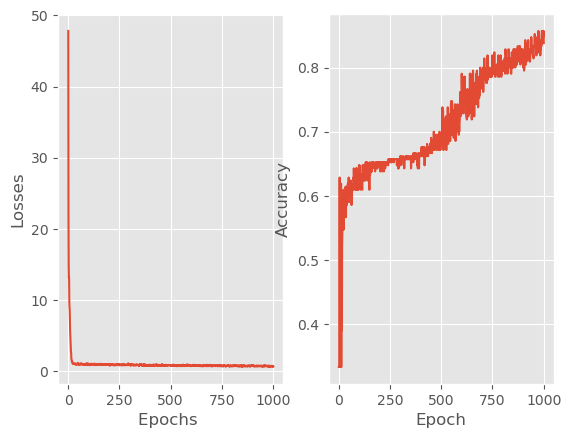

In [29]:
# hparameters and models
layer = [7,8,3]
num_epochs =1000
batch_size = 16
params2 = init_params(layer)
lr = 1e-3
optimizer2= SGD(params=params2, lr=lr)




# simple model without any hidden layer
import warnings
warnings.filterwarnings("ignore")
losses, acc = train(dataset=torch.tensor(data, dtype=torch.float32), num_epochs=num_epochs, lr=lr, 
                                batch_size=batch_size, params=params2, optimizer=optimizer2, dropout = True)            
style.use("ggplot")
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel("Epochs ")
plt.ylabel("Losses")
#plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

* #### *Can easily see that the model without regularization has got almost 90% accuracy on the training set and the model with regularization got only 83% accuracy andis preventing train set accuracy to go much higher so as to prevent overfitting*

* *Vanishing gradient problem can be caused by the choice of activation functions. For example the sigmoid activation function's deriviative gets closer to zero for large and small inputs, thus RELU() came to rescue as its gradients are finite for large values.*
* *Exploding gradient problem in deep neural network is due to the initialization.*
* *Good parametric initialization(focuses on breaking the symmetry problem), using good activation functions(focuses on vanishing gradient problem) and applying suitable regularization(focuses on exploding gradient problem) can always help in stable training.*

Accuracy 0.34285715222358704
Epoch[1], Current Loss: 5.25661563873291
Epoch[1], Current Loss: 3.787766933441162
Epoch[1], Current Loss: 6.700179100036621
Epoch[1], Current Loss: 4.618164539337158
Epoch[1], Current Loss: 2.584078550338745



Accuracy 0.34761905670166016
Epoch[2], Current Loss: 6.980589389801025
Epoch[2], Current Loss: 4.645500659942627
Epoch[2], Current Loss: 2.332627296447754
Epoch[2], Current Loss: 1.7729365825653076
Epoch[2], Current Loss: 2.8111586570739746



Accuracy 0.5
Epoch[3], Current Loss: 2.250753402709961
Epoch[3], Current Loss: 2.8043901920318604
Epoch[3], Current Loss: 1.1323472261428833
Epoch[3], Current Loss: 2.2492988109588623
Epoch[3], Current Loss: 2.149369716644287



Accuracy 0.3571428656578064
Epoch[4], Current Loss: 1.5720480680465698
Epoch[4], Current Loss: 1.4767773151397705
Epoch[4], Current Loss: 2.140350341796875
Epoch[4], Current Loss: 2.696613073348999
Epoch[4], Current Loss: 1.9046765565872192



Accuracy 0.3571428656578064
Epoch[5], Curr

Epoch[41], Current Loss: 1.5216600894927979



Accuracy 0.3333333432674408
Epoch[42], Current Loss: 1.1124200820922852
Epoch[42], Current Loss: 0.8899838924407959
Epoch[42], Current Loss: 1.0196702480316162
Epoch[42], Current Loss: 1.4601466655731201
Epoch[42], Current Loss: 1.6195685863494873



Accuracy 0.3333333432674408
Epoch[43], Current Loss: 1.272294044494629
Epoch[43], Current Loss: 0.880914032459259
Epoch[43], Current Loss: 1.180708885192871
Epoch[43], Current Loss: 1.7402622699737549
Epoch[43], Current Loss: 2.0295562744140625



Accuracy 0.3333333432674408
Epoch[44], Current Loss: 0.985024094581604
Epoch[44], Current Loss: 0.8039889335632324
Epoch[44], Current Loss: 1.086847186088562
Epoch[44], Current Loss: 1.739836573600769
Epoch[44], Current Loss: 1.6185301542282104



Accuracy 0.3333333432674408
Epoch[45], Current Loss: 0.9204137921333313
Epoch[45], Current Loss: 0.8734181523323059
Epoch[45], Current Loss: 0.9715591669082642
Epoch[45], Current Loss: 1.6304980516433716
Ep

Epoch[82], Current Loss: 1.4168449640274048



Accuracy 0.6190476417541504
Epoch[83], Current Loss: 1.0426801443099976
Epoch[83], Current Loss: 0.9639623165130615
Epoch[83], Current Loss: 1.0144950151443481
Epoch[83], Current Loss: 1.4318997859954834
Epoch[83], Current Loss: 1.2869997024536133



Accuracy 0.4238095283508301
Epoch[84], Current Loss: 1.0871483087539673
Epoch[84], Current Loss: 0.8537581562995911
Epoch[84], Current Loss: 0.9404836893081665
Epoch[84], Current Loss: 1.5114191770553589
Epoch[84], Current Loss: 1.3942495584487915



Accuracy 0.5952380895614624
Epoch[85], Current Loss: 1.1035641431808472
Epoch[85], Current Loss: 1.0003628730773926
Epoch[85], Current Loss: 0.9908239841461182
Epoch[85], Current Loss: 1.191867709159851
Epoch[85], Current Loss: 1.511650562286377



Accuracy 0.6238095164299011
Epoch[86], Current Loss: 1.0572538375854492
Epoch[86], Current Loss: 0.9411957263946533
Epoch[86], Current Loss: 0.9448569416999817
Epoch[86], Current Loss: 1.410801529884338

Epoch[121], Current Loss: 1.6346349716186523
Epoch[121], Current Loss: 1.60402250289917



Accuracy 0.3761904835700989
Epoch[122], Current Loss: 1.271820068359375
Epoch[122], Current Loss: 1.0686089992523193
Epoch[122], Current Loss: 0.9280381798744202
Epoch[122], Current Loss: 1.0913687944412231
Epoch[122], Current Loss: 1.2878456115722656



Accuracy 0.5571428537368774
Epoch[123], Current Loss: 1.0033087730407715
Epoch[123], Current Loss: 0.8716207146644592
Epoch[123], Current Loss: 0.8139399290084839
Epoch[123], Current Loss: 1.2696467638015747
Epoch[123], Current Loss: 1.3600260019302368



Accuracy 0.6190476417541504
Epoch[124], Current Loss: 0.9843398928642273
Epoch[124], Current Loss: 0.9123803973197937
Epoch[124], Current Loss: 0.9881075024604797
Epoch[124], Current Loss: 1.5437184572219849
Epoch[124], Current Loss: 1.3601922988891602



Accuracy 0.6190476417541504
Epoch[125], Current Loss: 0.9288991093635559
Epoch[125], Current Loss: 0.8801577687263489
Epoch[125], Current Loss

Epoch[168], Current Loss: 0.9520565271377563
Epoch[168], Current Loss: 1.0423067808151245
Epoch[168], Current Loss: 1.0885653495788574



Accuracy 0.5809524059295654
Epoch[169], Current Loss: 1.0318200588226318
Epoch[169], Current Loss: 0.9395180940628052
Epoch[169], Current Loss: 0.9133425951004028
Epoch[169], Current Loss: 1.0292541980743408
Epoch[169], Current Loss: 1.253598928451538



Accuracy 0.5142857432365417
Epoch[170], Current Loss: 1.1680843830108643
Epoch[170], Current Loss: 0.8475416898727417
Epoch[170], Current Loss: 0.9589588642120361
Epoch[170], Current Loss: 1.2632516622543335
Epoch[170], Current Loss: 1.1006073951721191



Accuracy 0.6047618985176086
Epoch[171], Current Loss: 0.9897177219390869
Epoch[171], Current Loss: 0.9884693622589111
Epoch[171], Current Loss: 0.8714697957038879
Epoch[171], Current Loss: 1.312248706817627
Epoch[171], Current Loss: 1.3235197067260742



Accuracy 0.5761904716491699
Epoch[172], Current Loss: 0.9144288301467896
Epoch[172], Current Los

Epoch[209], Current Loss: 0.9161965847015381
Epoch[209], Current Loss: 0.9654474258422852
Epoch[209], Current Loss: 0.9061682224273682
Epoch[209], Current Loss: 0.8979926109313965



Accuracy 0.738095223903656
Epoch[210], Current Loss: 0.9621484279632568
Epoch[210], Current Loss: 1.032430648803711
Epoch[210], Current Loss: 0.8500133752822876
Epoch[210], Current Loss: 0.9779242277145386
Epoch[210], Current Loss: 0.9459645748138428



Accuracy 0.7571428418159485
Epoch[211], Current Loss: 0.9378260374069214
Epoch[211], Current Loss: 0.8311594724655151
Epoch[211], Current Loss: 0.9377409219741821
Epoch[211], Current Loss: 0.8341150879859924
Epoch[211], Current Loss: 1.2645020484924316



Accuracy 0.7142857313156128
Epoch[212], Current Loss: 1.2947360277175903
Epoch[212], Current Loss: 0.9818259477615356
Epoch[212], Current Loss: 0.8368865251541138
Epoch[212], Current Loss: 1.1169397830963135
Epoch[212], Current Loss: 1.012363076210022



Accuracy 0.738095223903656
Epoch[213], Current Loss:

Epoch[247], Current Loss: 0.9734207987785339
Epoch[247], Current Loss: 0.8512376546859741
Epoch[247], Current Loss: 0.7050790190696716
Epoch[247], Current Loss: 0.9227430820465088



Accuracy 0.776190459728241
Epoch[248], Current Loss: 1.0056368112564087
Epoch[248], Current Loss: 0.9597435593605042
Epoch[248], Current Loss: 0.8723443746566772
Epoch[248], Current Loss: 0.8495712280273438
Epoch[248], Current Loss: 1.0682237148284912



Accuracy 0.800000011920929
Epoch[249], Current Loss: 1.2201483249664307
Epoch[249], Current Loss: 0.8275003433227539
Epoch[249], Current Loss: 0.9094941020011902
Epoch[249], Current Loss: 0.8457901477813721
Epoch[249], Current Loss: 0.9523168802261353



Accuracy 0.8428571224212646
Epoch[250], Current Loss: 1.1176564693450928
Epoch[250], Current Loss: 0.8486138582229614
Epoch[250], Current Loss: 0.922351598739624
Epoch[250], Current Loss: 1.0393767356872559
Epoch[250], Current Loss: 1.0546395778656006



Accuracy 0.8095238208770752
Epoch[251], Current Loss

Epoch[284], Current Loss: 0.9476301074028015
Epoch[284], Current Loss: 0.9407130479812622
Epoch[284], Current Loss: 0.8424026966094971



Accuracy 0.8571428656578064
Epoch[285], Current Loss: 0.960895836353302
Epoch[285], Current Loss: 0.882953941822052
Epoch[285], Current Loss: 0.8534603714942932
Epoch[285], Current Loss: 1.049363613128662
Epoch[285], Current Loss: 0.7969233393669128



Accuracy 0.8095238208770752
Epoch[286], Current Loss: 1.0717036724090576
Epoch[286], Current Loss: 0.7979093194007874
Epoch[286], Current Loss: 0.881942868232727
Epoch[286], Current Loss: 1.0867770910263062
Epoch[286], Current Loss: 0.666696310043335



Accuracy 0.8142856955528259
Epoch[287], Current Loss: 1.0788711309432983
Epoch[287], Current Loss: 1.0051629543304443
Epoch[287], Current Loss: 0.8796275854110718
Epoch[287], Current Loss: 0.737398087978363
Epoch[287], Current Loss: 0.8997519016265869



Accuracy 0.8380952477455139
Epoch[288], Current Loss: 0.9872124791145325
Epoch[288], Current Loss: 0

Epoch[321], Current Loss: 0.6274442076683044



Accuracy 0.8666666746139526
Epoch[322], Current Loss: 0.9525291323661804
Epoch[322], Current Loss: 0.94844651222229
Epoch[322], Current Loss: 0.8903544545173645
Epoch[322], Current Loss: 0.7531869411468506
Epoch[322], Current Loss: 0.8539690375328064



Accuracy 0.8476190567016602
Epoch[323], Current Loss: 0.9351034760475159
Epoch[323], Current Loss: 1.0473276376724243
Epoch[323], Current Loss: 0.8833673596382141
Epoch[323], Current Loss: 0.778230607509613
Epoch[323], Current Loss: 1.1452221870422363



Accuracy 0.8666666746139526
Epoch[324], Current Loss: 0.9079633355140686
Epoch[324], Current Loss: 0.9299914836883545
Epoch[324], Current Loss: 0.9094724059104919
Epoch[324], Current Loss: 0.7589985728263855
Epoch[324], Current Loss: 0.9908570647239685



Accuracy 0.8761904835700989
Epoch[325], Current Loss: 1.0284091234207153
Epoch[325], Current Loss: 0.9584996104240417
Epoch[325], Current Loss: 0.9536469578742981
Epoch[325], Current Loss

Epoch[360], Current Loss: 0.6706302165985107
Epoch[360], Current Loss: 0.7901372909545898



Accuracy 0.8619047403335571
Epoch[361], Current Loss: 0.8698629140853882
Epoch[361], Current Loss: 1.0264391899108887
Epoch[361], Current Loss: 0.8560181856155396
Epoch[361], Current Loss: 0.7423385381698608
Epoch[361], Current Loss: 0.7419063448905945



Accuracy 0.8666666746139526
Epoch[362], Current Loss: 0.9017028212547302
Epoch[362], Current Loss: 1.0164296627044678
Epoch[362], Current Loss: 0.8195546865463257
Epoch[362], Current Loss: 0.6739291548728943
Epoch[362], Current Loss: 0.7426893711090088



Accuracy 0.8476190567016602
Epoch[363], Current Loss: 0.965259313583374
Epoch[363], Current Loss: 0.9207242131233215
Epoch[363], Current Loss: 0.8348281383514404
Epoch[363], Current Loss: 0.7085154056549072
Epoch[363], Current Loss: 0.8578128814697266



Accuracy 0.8904761672019958
Epoch[364], Current Loss: 0.8823724389076233
Epoch[364], Current Loss: 0.9996657371520996
Epoch[364], Current Lo

Epoch[404], Current Loss: 0.8601542115211487
Epoch[404], Current Loss: 0.7798259258270264
Epoch[404], Current Loss: 0.6620660424232483



Accuracy 0.8523809313774109
Epoch[405], Current Loss: 0.9767042398452759
Epoch[405], Current Loss: 0.9078989624977112
Epoch[405], Current Loss: 0.8591687679290771
Epoch[405], Current Loss: 0.6772139072418213
Epoch[405], Current Loss: 0.6265056729316711



Accuracy 0.8523809313774109
Epoch[406], Current Loss: 0.9709381461143494
Epoch[406], Current Loss: 0.810400128364563
Epoch[406], Current Loss: 0.7900782823562622
Epoch[406], Current Loss: 0.5665268898010254
Epoch[406], Current Loss: 0.7717873454093933



Accuracy 0.8238095045089722
Epoch[407], Current Loss: 1.1346319913864136
Epoch[407], Current Loss: 0.9794585704803467
Epoch[407], Current Loss: 0.8101991415023804
Epoch[407], Current Loss: 0.6195482015609741
Epoch[407], Current Loss: 0.8430665135383606



Accuracy 0.8333333134651184
Epoch[408], Current Loss: 1.0430396795272827
Epoch[408], Current Lo

Epoch[446], Current Loss: 0.7194215655326843
Epoch[446], Current Loss: 0.5263170003890991



Accuracy 0.8904761672019958
Epoch[447], Current Loss: 0.8631099462509155
Epoch[447], Current Loss: 0.8505287766456604
Epoch[447], Current Loss: 0.8005444407463074
Epoch[447], Current Loss: 0.7377902865409851
Epoch[447], Current Loss: 0.6610358357429504



Accuracy 0.8809523582458496
Epoch[448], Current Loss: 0.9355058073997498
Epoch[448], Current Loss: 0.8324569463729858
Epoch[448], Current Loss: 0.8202237486839294
Epoch[448], Current Loss: 0.5714239478111267
Epoch[448], Current Loss: 0.689996063709259



Accuracy 0.8761904835700989
Epoch[449], Current Loss: 1.1076805591583252
Epoch[449], Current Loss: 0.963297963142395
Epoch[449], Current Loss: 0.773418128490448
Epoch[449], Current Loss: 0.8057147264480591
Epoch[449], Current Loss: 0.6837945580482483



Accuracy 0.8761904835700989
Epoch[450], Current Loss: 1.0431585311889648
Epoch[450], Current Loss: 0.9267333149909973
Epoch[450], Current Loss

Epoch[484], Current Loss: 0.6249327659606934
Epoch[484], Current Loss: 1.1248314380645752



Accuracy 0.8666666746139526
Epoch[485], Current Loss: 0.9446317553520203
Epoch[485], Current Loss: 1.0317209959030151
Epoch[485], Current Loss: 0.8407991528511047
Epoch[485], Current Loss: 0.6171655654907227
Epoch[485], Current Loss: 0.6616590023040771



Accuracy 0.8714285492897034
Epoch[486], Current Loss: 0.8577531576156616
Epoch[486], Current Loss: 0.8742466568946838
Epoch[486], Current Loss: 0.8524233102798462
Epoch[486], Current Loss: 0.6550390720367432
Epoch[486], Current Loss: 0.7638036012649536



Accuracy 0.8428571224212646
Epoch[487], Current Loss: 1.0314804315567017
Epoch[487], Current Loss: 0.9740467667579651
Epoch[487], Current Loss: 0.8663685321807861
Epoch[487], Current Loss: 0.7668519616127014
Epoch[487], Current Loss: 0.8068834543228149



Accuracy 0.8619047403335571
Epoch[488], Current Loss: 0.8702958226203918
Epoch[488], Current Loss: 0.8747337460517883
Epoch[488], Current L

Epoch[524], Current Loss: 0.8750905394554138
Epoch[524], Current Loss: 0.8309519290924072
Epoch[524], Current Loss: 0.580718457698822
Epoch[524], Current Loss: 0.8497198820114136



Accuracy 0.8809523582458496
Epoch[525], Current Loss: 0.8365049362182617
Epoch[525], Current Loss: 0.8955105543136597
Epoch[525], Current Loss: 0.7912439703941345
Epoch[525], Current Loss: 0.32836276292800903
Epoch[525], Current Loss: 0.8070182204246521



Accuracy 0.8857142925262451
Epoch[526], Current Loss: 0.9284546375274658
Epoch[526], Current Loss: 0.8102169632911682
Epoch[526], Current Loss: 0.8780098557472229
Epoch[526], Current Loss: 0.3052140474319458
Epoch[526], Current Loss: 0.43527984619140625



Accuracy 0.8809523582458496
Epoch[527], Current Loss: 0.8888814449310303
Epoch[527], Current Loss: 0.8753575086593628
Epoch[527], Current Loss: 0.8104830980300903
Epoch[527], Current Loss: 0.5611836910247803
Epoch[527], Current Loss: 0.49832814931869507



Accuracy 0.8380952477455139
Epoch[528], Current

Epoch[566], Current Loss: 0.8642964363098145
Epoch[566], Current Loss: 0.750067412853241
Epoch[566], Current Loss: 0.5591152906417847



Accuracy 0.9142857193946838
Epoch[567], Current Loss: 0.8876352310180664
Epoch[567], Current Loss: 0.9705660343170166
Epoch[567], Current Loss: 0.8075619339942932
Epoch[567], Current Loss: 0.6216853857040405
Epoch[567], Current Loss: 0.7961422204971313



Accuracy 0.9095237851142883
Epoch[568], Current Loss: 0.8315669894218445
Epoch[568], Current Loss: 1.0224637985229492
Epoch[568], Current Loss: 0.7595362663269043
Epoch[568], Current Loss: 0.38314369320869446
Epoch[568], Current Loss: 0.846275806427002



Accuracy 0.9142857193946838
Epoch[569], Current Loss: 0.8207277655601501
Epoch[569], Current Loss: 0.8595880270004272
Epoch[569], Current Loss: 0.7986387014389038
Epoch[569], Current Loss: 0.7726395130157471
Epoch[569], Current Loss: 0.6491365432739258



Accuracy 0.8904761672019958
Epoch[570], Current Loss: 1.0071648359298706
Epoch[570], Current Lo

Epoch[600], Current Loss: 0.3984561562538147



Accuracy 0.8809523582458496
Epoch[601], Current Loss: 0.9410427212715149
Epoch[601], Current Loss: 0.8821499943733215
Epoch[601], Current Loss: 0.8357821702957153
Epoch[601], Current Loss: 0.5690110921859741
Epoch[601], Current Loss: 0.6072895526885986



Accuracy 0.8999999761581421
Epoch[602], Current Loss: 0.9373290538787842
Epoch[602], Current Loss: 0.8248895406723022
Epoch[602], Current Loss: 0.7664018869400024
Epoch[602], Current Loss: 0.49436986446380615
Epoch[602], Current Loss: 0.5789854526519775



Accuracy 0.8666666746139526
Epoch[603], Current Loss: 0.845927894115448
Epoch[603], Current Loss: 0.8985966444015503
Epoch[603], Current Loss: 0.7807587385177612
Epoch[603], Current Loss: 0.47595587372779846
Epoch[603], Current Loss: 0.7324892282485962



Accuracy 0.9047619104385376
Epoch[604], Current Loss: 0.8209282755851746
Epoch[604], Current Loss: 0.9566773176193237
Epoch[604], Current Loss: 0.7001476883888245
Epoch[604], Current 

Epoch[637], Current Loss: 0.7939185500144958
Epoch[637], Current Loss: 0.7660306692123413
Epoch[637], Current Loss: 0.5985840559005737



Accuracy 0.8857142925262451
Epoch[638], Current Loss: 0.9162838459014893
Epoch[638], Current Loss: 0.8852956295013428
Epoch[638], Current Loss: 0.672547459602356
Epoch[638], Current Loss: 0.5995018482208252
Epoch[638], Current Loss: 0.5185195803642273



Accuracy 0.8619047403335571
Epoch[639], Current Loss: 0.8264692425727844
Epoch[639], Current Loss: 0.9054238200187683
Epoch[639], Current Loss: 0.775015652179718
Epoch[639], Current Loss: 0.6652121543884277
Epoch[639], Current Loss: 0.6289159655570984



Accuracy 0.8809523582458496
Epoch[640], Current Loss: 0.916913628578186
Epoch[640], Current Loss: 0.8474036455154419
Epoch[640], Current Loss: 0.8173799514770508
Epoch[640], Current Loss: 0.892606258392334
Epoch[640], Current Loss: 0.8306504487991333



Accuracy 0.8999999761581421
Epoch[641], Current Loss: 0.8774248957633972
Epoch[641], Current Loss:

Epoch[674], Current Loss: 0.6658126711845398
Epoch[674], Current Loss: 0.3786846399307251
Epoch[674], Current Loss: 0.8155147433280945



Accuracy 0.8333333134651184
Epoch[675], Current Loss: 0.8821364641189575
Epoch[675], Current Loss: 0.9383503198623657
Epoch[675], Current Loss: 0.7160176634788513
Epoch[675], Current Loss: 0.6883417367935181
Epoch[675], Current Loss: 0.6324007511138916



Accuracy 0.8571428656578064
Epoch[676], Current Loss: 0.8753204345703125
Epoch[676], Current Loss: 0.9440926909446716
Epoch[676], Current Loss: 0.6422675848007202
Epoch[676], Current Loss: 0.7417669296264648
Epoch[676], Current Loss: 0.7293062806129456



Accuracy 0.8428571224212646
Epoch[677], Current Loss: 0.9215781688690186
Epoch[677], Current Loss: 0.9305645227432251
Epoch[677], Current Loss: 0.8248125314712524
Epoch[677], Current Loss: 0.5752356052398682
Epoch[677], Current Loss: 0.9062931537628174



Accuracy 0.8523809313774109
Epoch[678], Current Loss: 0.8984267711639404
Epoch[678], Current L

Epoch[706], Current Loss: 0.5721074342727661
Epoch[706], Current Loss: 0.5420558452606201



Accuracy 0.8761904835700989
Epoch[707], Current Loss: 0.9018546938896179
Epoch[707], Current Loss: 0.9021366834640503
Epoch[707], Current Loss: 0.7077520489692688
Epoch[707], Current Loss: 0.5456802845001221
Epoch[707], Current Loss: 0.713837206363678



Accuracy 0.8904761672019958
Epoch[708], Current Loss: 0.8120301365852356
Epoch[708], Current Loss: 0.8640710711479187
Epoch[708], Current Loss: 0.7594594955444336
Epoch[708], Current Loss: 0.430666983127594
Epoch[708], Current Loss: 0.6922799944877625



Accuracy 0.7857142686843872
Epoch[709], Current Loss: 1.0401012897491455
Epoch[709], Current Loss: 1.0043601989746094
Epoch[709], Current Loss: 0.7880483865737915
Epoch[709], Current Loss: 0.8076421022415161
Epoch[709], Current Loss: 0.5749951601028442



Accuracy 0.8476190567016602
Epoch[710], Current Loss: 0.9210838079452515
Epoch[710], Current Loss: 0.8920754194259644
Epoch[710], Current Los

Epoch[740], Current Loss: 0.7100344896316528
Epoch[740], Current Loss: 0.7090663313865662
Epoch[740], Current Loss: 0.5983237028121948



Accuracy 0.800000011920929
Epoch[741], Current Loss: 0.9268879294395447
Epoch[741], Current Loss: 0.8026039004325867
Epoch[741], Current Loss: 0.793690025806427
Epoch[741], Current Loss: 0.15949012339115143
Epoch[741], Current Loss: 0.663154125213623



Accuracy 0.8523809313774109
Epoch[742], Current Loss: 0.845633327960968
Epoch[742], Current Loss: 0.8839927315711975
Epoch[742], Current Loss: 0.645330011844635
Epoch[742], Current Loss: 0.42554450035095215
Epoch[742], Current Loss: 0.6525205373764038



Accuracy 0.8666666746139526
Epoch[743], Current Loss: 0.8485555648803711
Epoch[743], Current Loss: 0.775478184223175
Epoch[743], Current Loss: 0.7224405407905579
Epoch[743], Current Loss: 0.37916886806488037
Epoch[743], Current Loss: 0.6724424362182617



Accuracy 0.8523809313774109
Epoch[744], Current Loss: 0.8493531346321106
Epoch[744], Current Loss

Accuracy 0.8285714387893677
Epoch[779], Current Loss: 0.9042366147041321
Epoch[779], Current Loss: 0.854852020740509
Epoch[779], Current Loss: 0.7143860459327698
Epoch[779], Current Loss: 0.3300473690032959
Epoch[779], Current Loss: 0.591925859451294



Accuracy 0.8428571224212646
Epoch[780], Current Loss: 0.797200083732605
Epoch[780], Current Loss: 0.8399465680122375
Epoch[780], Current Loss: 0.5322394371032715
Epoch[780], Current Loss: 0.3774579167366028
Epoch[780], Current Loss: 0.41603296995162964



Accuracy 0.8333333134651184
Epoch[781], Current Loss: 0.9002057313919067
Epoch[781], Current Loss: 0.9105145335197449
Epoch[781], Current Loss: 0.5492449998855591
Epoch[781], Current Loss: 0.309500128030777
Epoch[781], Current Loss: 0.7685237526893616



Accuracy 0.8476190567016602
Epoch[782], Current Loss: 0.9999268651008606
Epoch[782], Current Loss: 0.9342143535614014
Epoch[782], Current Loss: 0.5283623933792114
Epoch[782], Current Loss: 0.290283203125
Epoch[782], Current Loss: 1.092

Epoch[814], Current Loss: 0.8006097078323364
Epoch[814], Current Loss: 0.6696770191192627
Epoch[814], Current Loss: 0.8526723384857178
Epoch[814], Current Loss: 0.8802844882011414



Accuracy 0.8428571224212646
Epoch[815], Current Loss: 0.8517274260520935
Epoch[815], Current Loss: 0.9609085917472839
Epoch[815], Current Loss: 0.6259757280349731
Epoch[815], Current Loss: 0.2531704008579254
Epoch[815], Current Loss: 0.5516815185546875



Accuracy 0.8523809313774109
Epoch[816], Current Loss: 0.9312975406646729
Epoch[816], Current Loss: 0.9465014934539795
Epoch[816], Current Loss: 0.7107951045036316
Epoch[816], Current Loss: 0.3041902780532837
Epoch[816], Current Loss: 0.8874762654304504



Accuracy 0.8619047403335571
Epoch[817], Current Loss: 0.7793110609054565
Epoch[817], Current Loss: 0.9063631296157837
Epoch[817], Current Loss: 0.6807543635368347
Epoch[817], Current Loss: 0.4566781222820282
Epoch[817], Current Loss: 0.7405091524124146



Accuracy 0.8428571224212646
Epoch[818], Current L

Epoch[851], Current Loss: 0.9497019052505493



Accuracy 0.8142856955528259
Epoch[852], Current Loss: 0.9769889712333679
Epoch[852], Current Loss: 0.90313321352005
Epoch[852], Current Loss: 0.6711344718933105
Epoch[852], Current Loss: 0.8973423838615417
Epoch[852], Current Loss: 0.3693752884864807



Accuracy 0.8523809313774109
Epoch[853], Current Loss: 0.7970835566520691
Epoch[853], Current Loss: 0.9615765810012817
Epoch[853], Current Loss: 0.46971839666366577
Epoch[853], Current Loss: 0.33022335171699524
Epoch[853], Current Loss: 0.6704192161560059



Accuracy 0.8666666746139526
Epoch[854], Current Loss: 0.9051389694213867
Epoch[854], Current Loss: 0.8860134482383728
Epoch[854], Current Loss: 0.5812994241714478
Epoch[854], Current Loss: 0.599012553691864
Epoch[854], Current Loss: 0.6770532131195068



Accuracy 0.8285714387893677
Epoch[855], Current Loss: 0.832929253578186
Epoch[855], Current Loss: 0.8240361213684082
Epoch[855], Current Loss: 0.6149744391441345
Epoch[855], Current Los




Accuracy 0.8428571224212646
Epoch[886], Current Loss: 0.9413055777549744
Epoch[886], Current Loss: 0.8832768797874451
Epoch[886], Current Loss: 0.7515631318092346
Epoch[886], Current Loss: 0.5572688579559326
Epoch[886], Current Loss: 0.7058603763580322



Accuracy 0.8428571224212646
Epoch[887], Current Loss: 0.7701241374015808
Epoch[887], Current Loss: 0.9242433905601501
Epoch[887], Current Loss: 0.4358568489551544
Epoch[887], Current Loss: 0.6029529571533203
Epoch[887], Current Loss: 0.6058669686317444



Accuracy 0.8380952477455139
Epoch[888], Current Loss: 0.8029028177261353
Epoch[888], Current Loss: 0.7310790419578552
Epoch[888], Current Loss: 0.6480454206466675
Epoch[888], Current Loss: 0.3860912621021271
Epoch[888], Current Loss: 0.5069882869720459



Accuracy 0.8476190567016602
Epoch[889], Current Loss: 0.8653281331062317
Epoch[889], Current Loss: 0.8650267720222473
Epoch[889], Current Loss: 0.6937358379364014
Epoch[889], Current Loss: 0.5726771950721741
Epoch[889], Current L




Accuracy 0.8904761672019958
Epoch[934], Current Loss: 0.7595458030700684
Epoch[934], Current Loss: 0.8736735582351685
Epoch[934], Current Loss: 0.5844130516052246
Epoch[934], Current Loss: 0.20817391574382782
Epoch[934], Current Loss: 0.9345026612281799



Accuracy 0.8999999761581421
Epoch[935], Current Loss: 0.7613993883132935
Epoch[935], Current Loss: 0.7658879160881042
Epoch[935], Current Loss: 0.4883057475090027
Epoch[935], Current Loss: 0.28874170780181885
Epoch[935], Current Loss: 0.6993821263313293



Accuracy 0.8857142925262451
Epoch[936], Current Loss: 0.7836012840270996
Epoch[936], Current Loss: 0.7740583419799805
Epoch[936], Current Loss: 0.40347665548324585
Epoch[936], Current Loss: 0.4237383008003235
Epoch[936], Current Loss: 0.5487294793128967



Accuracy 0.8619047403335571
Epoch[937], Current Loss: 0.8934647440910339
Epoch[937], Current Loss: 0.7389615774154663
Epoch[937], Current Loss: 0.6641498804092407
Epoch[937], Current Loss: 0.4995969235897064
Epoch[937], Curren




Accuracy 0.8666666746139526
Epoch[971], Current Loss: 0.8537926077842712
Epoch[971], Current Loss: 0.7441539764404297
Epoch[971], Current Loss: 0.5899853110313416
Epoch[971], Current Loss: 0.7561866044998169
Epoch[971], Current Loss: 0.32904699444770813



Accuracy 0.8714285492897034
Epoch[972], Current Loss: 0.8241549134254456
Epoch[972], Current Loss: 0.7511775493621826
Epoch[972], Current Loss: 0.5915378928184509
Epoch[972], Current Loss: 0.5461646914482117
Epoch[972], Current Loss: 0.564685583114624



Accuracy 0.8571428656578064
Epoch[973], Current Loss: 0.7854120135307312
Epoch[973], Current Loss: 0.7160589098930359
Epoch[973], Current Loss: 0.3648321032524109
Epoch[973], Current Loss: 0.5222610235214233
Epoch[973], Current Loss: 0.49245041608810425



Accuracy 0.8619047403335571
Epoch[974], Current Loss: 0.9197420477867126
Epoch[974], Current Loss: 0.8491474390029907
Epoch[974], Current Loss: 0.47670412063598633
Epoch[974], Current Loss: 0.7188698649406433
Epoch[974], Current

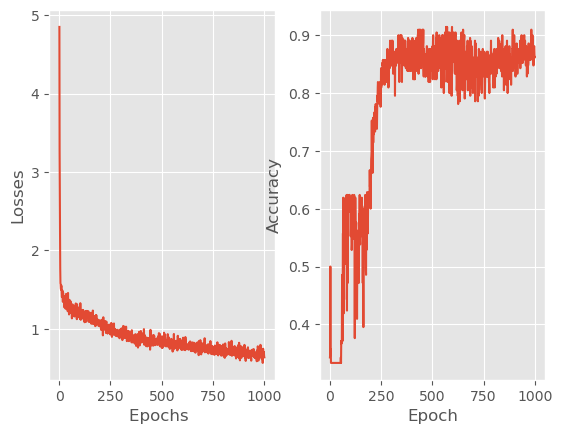

In [44]:
# hparameters and models
layer = [7,8,4,3]
num_epochs = 1000
batch_size = 16
params3 = xavier_initialization(layer)
lr = 1e-3
optimizer3 = SGD(params=params3, lr=lr)



# simple model without any hidden layer
import warnings
warnings.filterwarnings("ignore")
losses, acc = train(dataset=torch.tensor(data, dtype=torch.float32), num_epochs=num_epochs, lr=lr, 
                                batch_size=batch_size, params=params3, optimizer=optimizer3, dropout = True)            
style.use("ggplot")
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel("Epochs ")
plt.ylabel("Losses")
#plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()